# Capstone Project - Car Accident Severity
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data acquisition and cleaning](#data)
* [Methodology](#methodology)
* [Modelling](#modelling)
* [Results and discussion](#results)
* [Conclusion](#conclusion)

## Business Problem <a name="introduction"></a>

In 2015 the Seattle Department of Transportation (SDOT) launched the "Vision Zero" program which aims to end traffic deaths and serious injuries by 2030. The foundation of the project is "traffic collisions aren't accidents - they're preventable through smarter street design, targeted enforcement, partnerships, and thoughtful public engagement". 

The 2015 Vision Zero Action Plan states that traffic collisions are a leading cause of death for Seattle residents age 5-24. Older adults are also disproportionately affected, and as its population ages, this trend could grow. In 2013, there were 10,310 police-reported collisions in Seattle. 155 people were seriously injured and 23 were killed. 

This report aims to identify how internal and external conditions relate to car collisions and to calculate the probability of getting property damage or get injured in a car accident. This information might be used in street signs to alert drivers and strengthen an attentive driving. 

The targets of the project are the Seattle Department of Transportation and other public or private organization working on decrease de number of traffic accidents in Seattle, Washington.


## Data <a name="data"></a>

The “City of Seattle Open Data” portal provides under the Transportation category a variety of data sets which include traffic flow counts, collisions, intersections, marked crosswalks, one-way Streets and others.   

For this project we will be working with the Collision dataset. The dataset consists of 40 columns with 221266 number of observations from 2004 to present. There is no duplicate rows and the percentage of missing cells is 15.8%. Across the columns we have different data types: categorical, numerical and Boolean. 

[Source of dataset](https://data.seattle.gov/Land-Base/Collisions/9kas-rb8d)

[Detailed description of attributes](https://www.seattle.gov/Documents/Departments/SDOT/GIS/Collisions_OD.pdf)


In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df= pd.read_csv(r"C:\Users\Usuario\Documents\Data Science\Cursos\IBM\Course 9\Collisions.csv")

According to the dataset summary provided by SDOT some of the attributes represent a unique key for the collision. For the purpose of this project this kind of information it is of no use. Because of that, the following columns will be deleted from the data set:
- OBJECTID
- INCKEY
- COLDETKEY
- INTKEY
- SEGLANEKEY
- CROSSWALKKEY
- SDOTCOLNUM


In [3]:
df.drop(['OBJECTID', 'INCKEY', 'COLDETKEY', 'INTKEY', 'SDOTCOLNUM', 'SEGLANEKEY', 'CROSSWALKKEY'], 
        axis=1, inplace=True)

The columns with a description of another attribute add no information to the analysis. Because of that, the following columns will be deleted from the data set:
- LOCATION
- SEVERITYDESC
- SDOT_COLDESC
- ST_COLDESC

In [4]:
df.drop(['SEVERITYDESC', 'SDOT_COLDESC', 'ST_COLDESC'],axis=1, inplace=True)

There are also some columns which are not included in the dataset summary or has no description in it. Also, its values will no represent additional important information for this project. Because of that, the following columns will be deleted from the data set:
- REPORTNO
- EXCEPTRSNCODE
- EXCEPTRSNDESC
- STATUS

In [5]:
df.drop(['REPORTNO', 'EXCEPTRSNCODE', 'EXCEPTRSNDESC', 'STATUS'],axis=1, inplace=True)

The SDOT_COLCODE columns gives a particular code for every type of the collision. According to the State Collision Code Dictionary there are 84 different types of collision. To simplify the analysis instead of using this column we will be use the COLLISIONTYPE attribute which is a reduced classification of collisions. 

In [6]:
df.drop(['SDOT_COLCODE'],axis=1, inplace=True)

To analyse the evolution of collision across the years, months, days and hours we will generate the following columns from the INCDATE and INCDTTM attribute which has values about the date and time of the incident: - YEAR, -MONTH, -DAY, -HOUR. The INCDTTM has no time values for some records because of that, first we need to convert to missing value those entrances with no time information and then create the HOUR feature.

Once generated those new features, we will drop the INCDATE and INCDTTM columns.


In [7]:
df['INCDATE'] = pd.to_datetime(df['INCDATE'])
df['YEAR'] = df['INCDATE'].dt.year
df['MONTH'] = df['INCDATE'].dt.month
df['DAY'] = df['INCDATE'].dt.dayofweek

In [8]:
mask= (df['INCDTTM'].str.contains('AM'))| (df['INCDTTM'].str.contains('PM'))
df.loc[~mask, 'INCDTTM'] = np.nan
df['INCDTTM'] = pd.to_datetime(df['INCDTTM'])
df['HOUR'] = df['INCDTTM'].dt.hour

In [9]:
df.drop(['INCDTTM', 'INCDATE'], axis=1, inplace=True)

## Methodology: EDA <a name="methodology"></a>

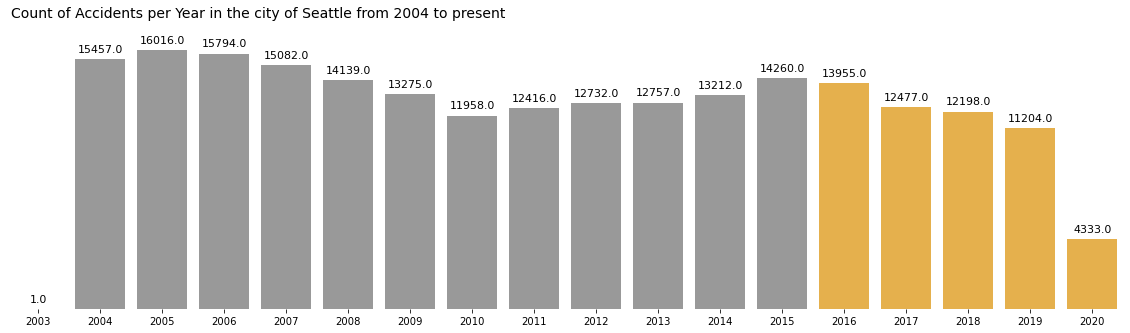

In [10]:
plt.figure(figsize=(20,5))
year_values = df['YEAR'].value_counts().sort_index()
clrs = ['grey' if (x <2016) else 'orange' for x in year_values.index]
ax=sns.barplot(x=year_values.index, y=year_values.values, alpha=0.8, palette=clrs)
ax.set_title('Count of Accidents per Year in the city of Seattle from 2004 to present', y=1.05, x=0.225, fontsize=14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_yaxis().set_visible(False)

for p in ax.patches:
    ax.annotate(format(p.get_height()), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=11,
                   xytext = (0, +10), 
                   textcoords = 'offset points')
figure = ax.get_figure()    
figure.savefig('year.png', dpi=400)

First, there is a low value in 2003. Probably this is a wrong entry so we should delete it. 
From 2016 we can see a reduction tendency of the global number of collisions. The low number from 2020 is probably related to COVID19 and some lockdown and circulation restriction. Because that is an extremely rare situation, we will drop values from 2020 too. 


In [11]:
df.drop(df[df['YEAR'] == 2003].index, inplace = True) 
df.drop(df[df['YEAR'] == 2020].index, inplace = True) 
df.reset_index(drop=True, inplace=True)

The interest of the Vision Zero project is to reduce the number of death and serious injuries, so let us analyse its evolution across the years.

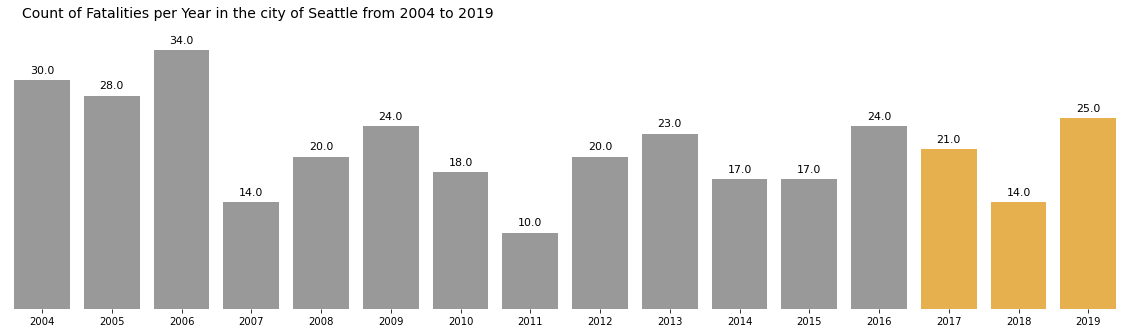

In [12]:
plt.figure(figsize=(20,5))
death_cases = df[df['SEVERITYCODE']=='3']['YEAR'].value_counts().sort_index()
clrs = ['grey' if (x <2016) else 'orange' for x in year_values.index]
ax=sns.barplot(x=death_cases.index, y=death_cases.values, alpha=0.8, palette=clrs)
ax.set_title('Count of Fatalities per Year in the city of Seattle from 2004 to 2019', y=1.05, x=0.225, fontsize=14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_yaxis().set_visible(False)

for p in ax.patches:
    ax.annotate(format(p.get_height()), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=11,
                   xytext = (0, +10), 
                   textcoords = 'offset points')
figure = ax.get_figure()    
figure.savefig('death.png', dpi=400)

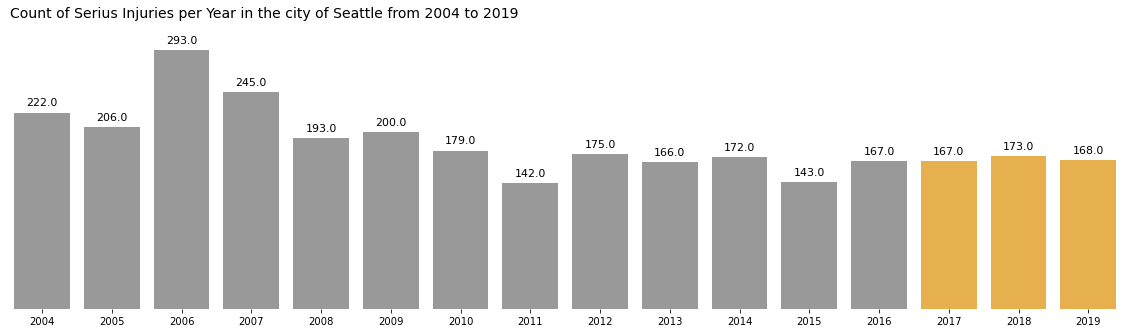

In [13]:
plt.figure(figsize=(20,5))
serius_cases = df[df['SEVERITYCODE']=='2b']['YEAR'].value_counts().sort_index()
clrs = ['grey' if (x <2016) else 'orange' for x in year_values.index]
ax=sns.barplot(x=serius_cases.index, y=serius_cases.values, alpha=0.8, palette=clrs)
ax.set_title('Count of Serius Injuries per Year in the city of Seattle from 2004 to 2019', y=1.05, x=0.23, fontsize=14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_yaxis().set_visible(False)

for p in ax.patches:
    ax.annotate(format(p.get_height()), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=11,
                   xytext = (0, +10), 
                   textcoords = 'offset points')
figure = ax.get_figure()    
figure.savefig('serius.png', dpi=400)

Despite there is a reduction in the number of collisions since 2016, the number of fatalities and cases with serious injuries have no change for the same period. On average, 21 families lost someone who loved because of the fatality of the accident and 675 people got injured. 

In [14]:
focus = df[(df['SEVERITYCODE']=='2b')|(df['SEVERITYCODE']=='3')]
heat_df = focus.dropna(axis=0, subset=['X','Y'])

In [15]:
import folium
from folium import plugins
from folium.plugins import HeatMap

seattle_map = folium.Map(location=[47.608013, -122.335167],  zoom_start=11, control_scale=True)

HeatMap(data=heat_df[['X','Y','SERIOUSINJURIES']].groupby(['Y', 'X']).sum().reset_index().values.tolist(), radius=8, max_zoom=5).add_to(seattle_map)

seattle_map.save(r'C:\Users\Usuario\Documents\Data Science\Cursos\IBM\Course 9\map_sf.html')
seattle_map

In [16]:
seattle_map = folium.Map(location=[47.608013, -122.335167],  zoom_start=11, control_scale=True)

HeatMap(data=heat_df[['X','Y','FATALITIES']].groupby(['Y', 'X']).sum().reset_index().values.tolist(), radius=8, max_zoom=5).add_to(seattle_map)

seattle_map.save(r'C:\Users\Usuario\Documents\Data Science\Cursos\IBM\Course 9\fatal_sf.html')
seattle_map

Those type of collisions take place across the city of Seattle. There are some locations with a higher number of occurrences. The following are the top five:

In [17]:
df.groupby('LOCATION')['SERIOUSINJURIES'].sum().sort_values(ascending=False).head()

LOCATION
AURORA BR BETWEEN RAYE ST AND BRIDGE WAY N                    46
OLSON PL SW BETWEEN 3RD AVE SW AND SW CAMBRIDGE PL            13
RAINIER AVE S BETWEEN S MOUNT BAKER EB BV AND S HANFORD ST     8
15TH AVE NW AND NW MARKET ST                                   7
AURORA AVE N BETWEEN N 130TH ST AND N 135TH ST                 7
Name: SERIOUSINJURIES, dtype: int64

In [18]:
df.groupby('LOCATION')['FATALITIES'].sum().sort_values(ascending=False).head()

LOCATION
AURORA BR BETWEEN RAYE ST AND BRIDGE WAY N                                    5
ALASKAN WY VI SB BETWEEN ALASKAN WY VI SB EFR OFF RP AND S HOLGATE ST         4
RAINIER AVE S BETWEEN 57TH AVE S AND ITHACA PL S                              4
ALASKAN WY VI SB BETWEEN COLUMBIA ST ON RP AND ALASKAN WY VI SB EFR OFF RP    4
ALASKAN WY VI NB BETWEEN S ROYAL BROUGHAM WAY ON RP AND SENECA ST OFF RP      4
Name: FATALITIES, dtype: int64

Because the aim of the report is to generate insights for the Vision Zero project or for another institution which works to decrease the number of fatalities and serious injuries, from now and on we will analyse those types of collisions. 

Let us look what are the types of collisions.

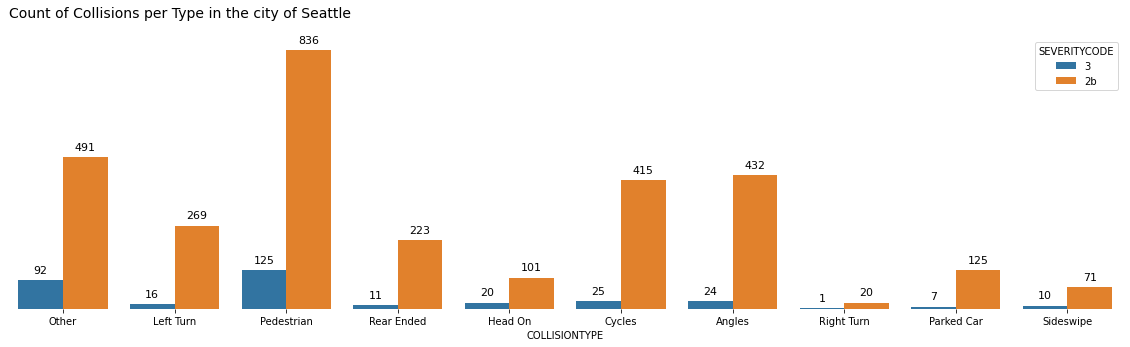

In [19]:
plt.figure(figsize=(20,5))
ax=sns.countplot(x='COLLISIONTYPE', hue='SEVERITYCODE', data=focus)

ax.set_title('Count of Collisions per Type in the city of Seattle', y=1.05, x=0.155, fontsize=14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_yaxis().set_visible(False)

for p in ax.patches:
    ax.annotate(format(p.get_height()), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=11,
                   xytext = (0, +10), 
                   textcoords = 'offset points')

figure = ax.get_figure()    
figure.savefig('type.png', dpi=400)

The first type of collision which cause a serious injured or fatality involve a pedestrian. Also, bicycles occupied the 3rd position. Let us see the collision address type and the category of junction at which collision took place.

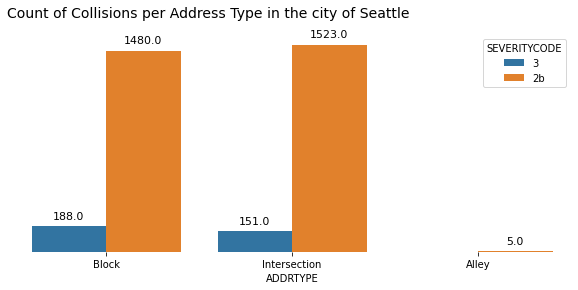

In [20]:
plt.figure(figsize=(10,4))
ax=sns.countplot(x='ADDRTYPE', hue='SEVERITYCODE', data=focus)

ax.set_title('Count of Collisions per Address Type in the city of Seattle', y=1.05, x=0.35, fontsize=14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_yaxis().set_visible(False)

for p in ax.patches:
    ax.annotate(format(p.get_height()), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=11,
                   xytext = (0, +10), 
                   textcoords = 'offset points')

figure = ax.get_figure()    
figure.savefig('address.png', dpi=400)

In [21]:
focus['JUNCTIONTYPE'].value_counts(normalize=True)

At Intersection (intersection related)               0.492645
Mid-Block (not related to intersection)              0.392975
Mid-Block (but intersection related)                 0.061243
Driveway Junction                                    0.043831
At Intersection (but not related to intersection)    0.007805
Ramp Junction                                        0.001501
Name: JUNCTIONTYPE, dtype: float64

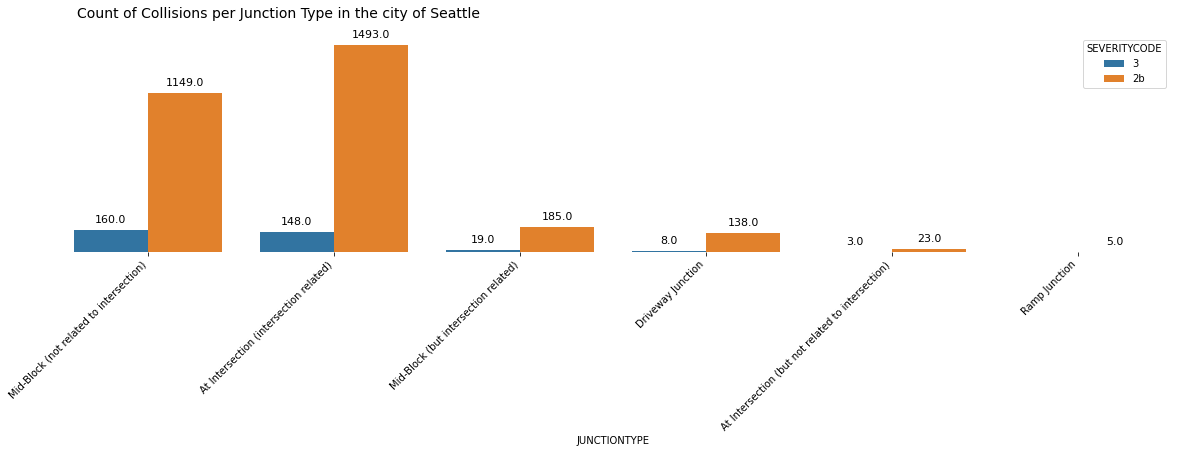

In [22]:
plt.figure(figsize=(20,4))
ax=sns.countplot(x='JUNCTIONTYPE', hue='SEVERITYCODE', data=focus)

ax.set_title('Count of Collisions per Junction Type in the city of Seattle', y=1.05, x=0.2, fontsize=14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_yaxis().set_visible(False)

for p in ax.patches:
    ax.annotate(format(p.get_height()), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=11,
                   xytext = (0, +10), 
                   textcoords = 'offset points')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

figure = ax.get_figure()    
figure.savefig('junction.png', dpi=400)

It would be interesting to analyse the number and position of traffic light across the city of Seattle and the existence of crosswalk and bicycle line. But this is not the scope of this project. It would be a theme for future analysis. Nevertheless, the PEDROWNOTGRNT feature could give us some insight about it. 

In [23]:
focus['PEDROWNOTGRNT'].value_counts(normalize=True, dropna=False)

NaN    0.857313
Y      0.142687
Name: PEDROWNOTGRNT, dtype: float64

This feature content a high number of missing data. An analysis of its values reveals that the only no null value is Y = yes. So, first we need to replace those missing values to N = no. For a cleaner data manipulation let us change in the df dataset and not only in the focus dataset.

In [24]:
df['PEDROWNOTGRNT'] = df['PEDROWNOTGRNT'].replace(np.nan, 'N')

In [25]:
focus = df[(df['SEVERITYCODE']=='2b')|(df['SEVERITYCODE']=='3')]

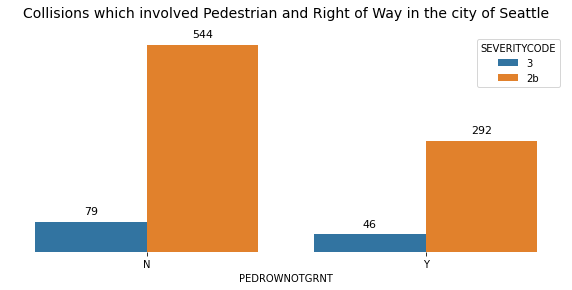

In [26]:
plt.figure(figsize=(10,4))
ax=sns.countplot(x='PEDROWNOTGRNT', hue='SEVERITYCODE', data=focus[focus['COLLISIONTYPE']=='Pedestrian'])

ax.set_title('Collisions which involved Pedestrian and Right of Way in the city of Seattle', y=1.05, x=0.5, fontsize=14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_yaxis().set_visible(False)

for p in ax.patches:
    ax.annotate(format(p.get_height()), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=11,
                   xytext = (0, +10), 
                   textcoords = 'offset points')

figure = ax.get_figure()    
figure.savefig('right_of_way.png', dpi=400)

According to the Washington State Department of Transportation drivers and bicyclists must yield to pedestrians on sidewalks and in crosswalks. But every pedestrian crossing a roadway at any point other than within a marked crosswalk or within an unmarked crosswalk at an intersection shall yield the right of way to all vehicles upon the roadway. From the graph we can say that the most cases occurs when the pedestrian right of way is not granted. We need a deeper analysis to understand if the collision is due to inattention of the pedestrian when crossing the street.

Let us analyse again the distribution of collision per address type but in this case only for collisions which involve a pedestrian.

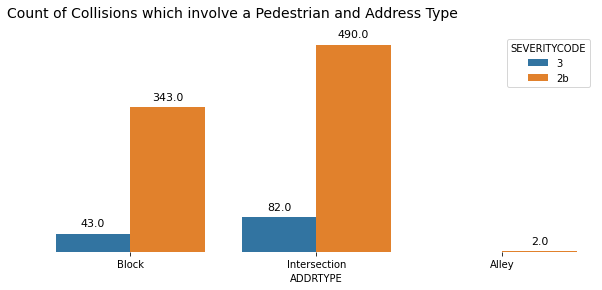

In [27]:
plt.figure(figsize=(10,4))
ax=sns.countplot(x='ADDRTYPE', hue='SEVERITYCODE', data=focus[focus['COLLISIONTYPE']=='Pedestrian'])

ax.set_title('Count of Collisions which involve a Pedestrian and Address Type', y=1.05, x=0.35, fontsize=14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_yaxis().set_visible(False)

for p in ax.patches:
    ax.annotate(format(p.get_height()), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=11,
                   xytext = (0, +10), 
                   textcoords = 'offset points')

figure = ax.get_figure()    
figure.savefig('address_.png', dpi=400)

Most cases occur at intersection. Again it would be valuable to analyse the existence of crosswalks and traffic lights at intersections.

Let us see now other external condition that may affect the driving like road condition, weather and level of light.

#### ROAD CONDITION

In [28]:
focus['ROADCOND'].value_counts(normalize=True)

Dry               0.738002
Wet               0.242680
Unknown           0.009357
Ice               0.005735
Snow/Slush        0.002415
Other             0.000906
Standing Water    0.000906
Name: ROADCOND, dtype: float64

Let us replace the Other values and Unknown values to missing data because it does not add useful information.

In [29]:
df['ROADCOND'].replace('Unknown', np.nan, inplace=True)
df['ROADCOND'].replace('Other', np.nan, inplace=True)

In [30]:
focus = df[(df['SEVERITYCODE']=='2b')|(df['SEVERITYCODE']=='3')]

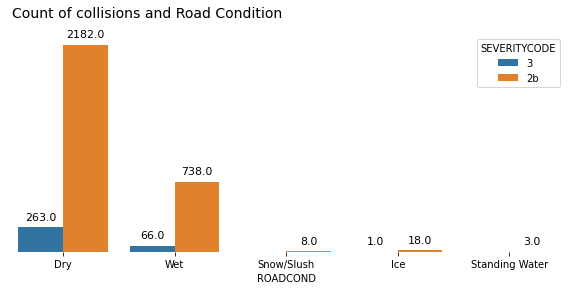

In [31]:
plt.figure(figsize=(10,4))
ax=sns.countplot(x='ROADCOND', hue='SEVERITYCODE', data=focus)

ax.set_title('Count of collisions and Road Condition', y=1.05, x=0.25, fontsize=14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_yaxis().set_visible(False)

for p in ax.patches:
    ax.annotate(format(p.get_height()), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=11,
                   xytext = (0, +10), 
                   textcoords = 'offset points')

figure = ax.get_figure()    
figure.savefig('road.png', dpi=400)

Most of the time the road condition is dry, so it seems that this feature it is not the main cause of collisions. 

#### WEATHER CONDITION

In [32]:
focus['WEATHER'].value_counts()

Clear                       2199
Raining                      563
Overcast                     478
Unknown                       40
Other                         10
Snowing                        9
Fog/Smog/Smoke                 6
Sleet/Hail/Freezing Rain       2
Severe Crosswind               1
Name: WEATHER, dtype: int64

Let us replace the Other values and Unknown values to missing data because it does not add useful information.

In [33]:
df['WEATHER'].replace('Unknown', np.nan, inplace=True)
df['WEATHER'].replace('Other', np.nan, inplace=True)

In [34]:
focus = df[(df['SEVERITYCODE']=='2b')|(df['SEVERITYCODE']=='3')]

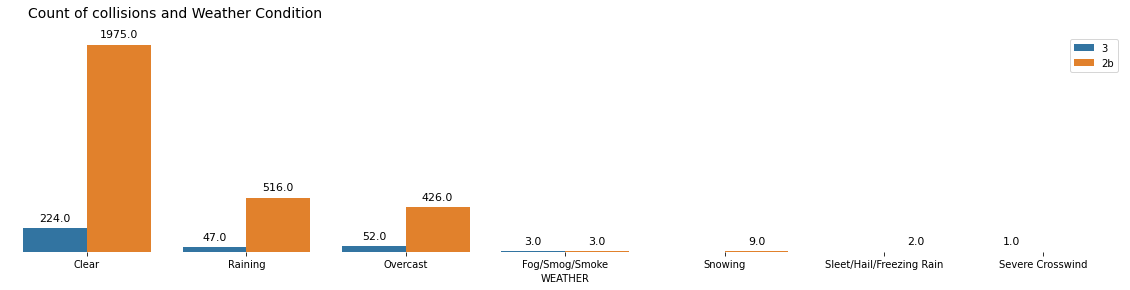

In [35]:
plt.figure(figsize=(20,4))
ax=sns.countplot(x='WEATHER', hue='SEVERITYCODE', data=focus)

ax.set_title('Count of collisions and Weather Condition', y=1.05, x=0.15, fontsize=14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_yaxis().set_visible(False)

for p in ax.patches:
    ax.annotate(format(p.get_height()), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=11,
                   xytext = (0, +10), 
                   textcoords = 'offset points')
plt.legend(loc='upper right')
    
figure = ax.get_figure()    
figure.savefig('weather.png', dpi=400)

In most cases the collisions occur under clear weather. It makes sense because we see this tendency under dry road.

#### LIGHT CONDITION

In [36]:
focus['LIGHTCOND'].value_counts()

Daylight                    1910
Dark - Street Lights On     1127
Dusk                         120
Dawn                          63
Dark - Street Lights Off      32
Unknown                       26
Dark - No Street Lights       25
Other                          4
Name: LIGHTCOND, dtype: int64

Let us replace the Other values and Unknown values to missing data because it does not add useful information.

In [37]:
df['LIGHTCOND'].replace('Unknown', np.nan, inplace=True)
df['LIGHTCOND'].replace('Other', np.nan, inplace=True)

In [38]:
focus = df[(df['SEVERITYCODE']=='2b')|(df['SEVERITYCODE']=='3')]

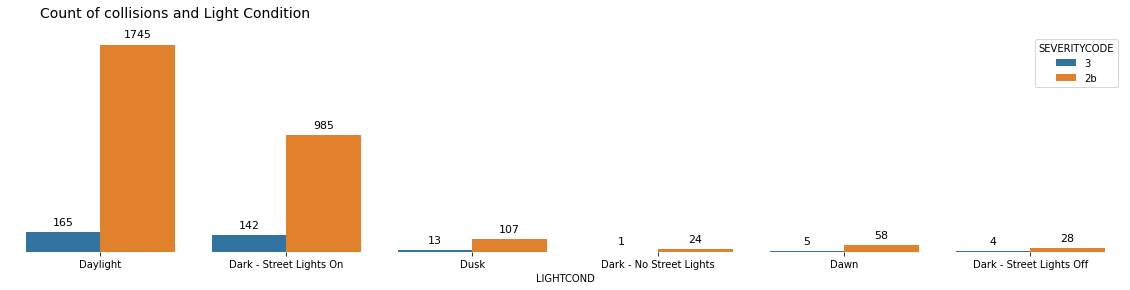

In [39]:
plt.figure(figsize=(20,4))
ax=sns.countplot(x='LIGHTCOND', hue='SEVERITYCODE', data=focus)

ax.set_title('Count of collisions and Light Condition', y=1.05, x=0.15, fontsize=14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_yaxis().set_visible(False)

for p in ax.patches:
    ax.annotate(format(p.get_height()), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=11,
                   xytext = (0, +10), 
                   textcoords = 'offset points')

figure = ax.get_figure()    
figure.savefig('light.png', dpi=400)

#### TIME

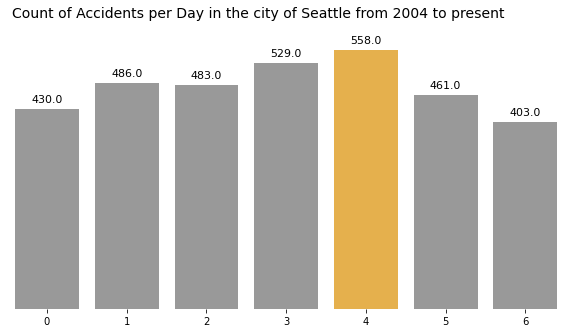

In [40]:
day_values = focus['DAY'].value_counts().sort_index()
clrs = ['grey' if (x <max(day_values)) else 'orange' for x in day_values]
plt.figure(figsize=(10,5))
ax=sns.barplot(x=day_values.index, y=day_values.values, alpha=0.8, palette=clrs)
ax.set_title('Count of Accidents per Day in the city of Seattle from 2004 to present', y=1.05, x=0.45, fontsize=14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_yaxis().set_visible(False)

for p in ax.patches:
    ax.annotate(format(p.get_height()), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=11,
                   xytext = (0, +10), 
                   textcoords = 'offset points')

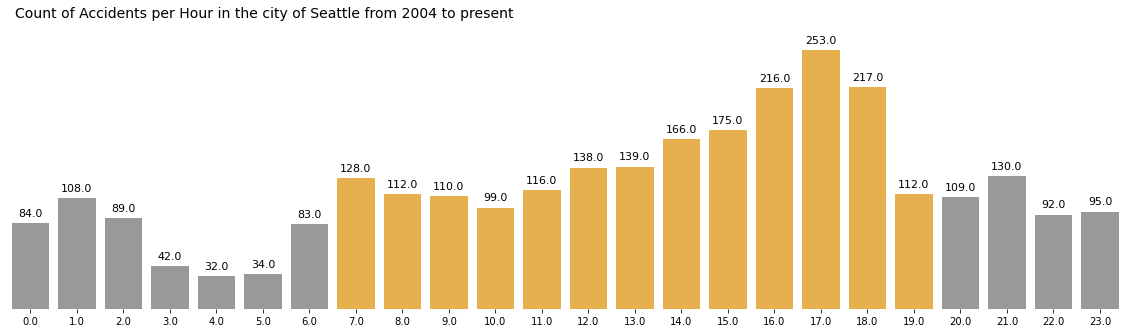

In [41]:
hour_values = focus['HOUR'].value_counts().sort_index()
clrs = ['grey' if (x >19 or x <7) else 'orange' for x in hour_values.index]
plt.figure(figsize=(20,5))
ax=sns.barplot(x=hour_values.index, y=hour_values.values, alpha=0.8, palette=clrs)
ax.set_title('Count of Accidents per Hour in the city of Seattle from 2004 to present', y=1.05, x=0.23, fontsize=14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_yaxis().set_visible(False)

for p in ax.patches:
    ax.annotate(format(p.get_height()), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=11,
                   xytext = (0, +10), 
                   textcoords = 'offset points')

In most cases the collisions occur on Friday. On the other hand, the 75% of cases occur between 7 A.M and 19 A.M. It is related with what we saw in Light Condition chart.

Let us analyse some internal conditions which may be related with collisions.

#### UNDER INFLUENCE OF ALCOHOL OR DRUGS

In [42]:
focus['UNDERINFL'].value_counts()

N    1525
0    1284
Y     270
1     235
Name: UNDERINFL, dtype: int64

The values of this feature are Y and 1 for yes, N and 0 for no. Let us replace 1 to Y and 0 to N.

In [43]:
df['UNDERINFL'].replace('0', 'N', inplace=True)
df['UNDERINFL'].replace('1', 'Y', inplace=True)

In [44]:
focus = df[(df['SEVERITYCODE']=='2b')|(df['SEVERITYCODE']=='3')]

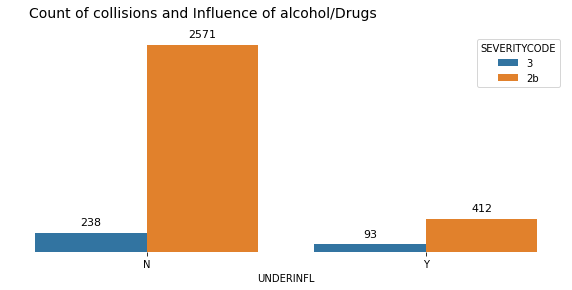

In [45]:
plt.figure(figsize=(10,4))
ax=sns.countplot(x='UNDERINFL', hue='SEVERITYCODE', data=focus)

ax.set_title('Count of collisions and Influence of alcohol/Drugs', y=1.05, x=0.35, fontsize=14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_yaxis().set_visible(False)

for p in ax.patches:
    ax.annotate(format(p.get_height()), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=11,
                   xytext = (0, +10), 
                   textcoords = 'offset points')

figure = ax.get_figure()    
figure.savefig('influece.png', dpi=400)

The 28% of cases which lead on fatality were related to a driver under influence of alcohol or drugs.

#### INATTENTION

In [46]:
focus['INATTENTIONIND'].value_counts(normalize=True, dropna=False)

NaN    0.887463
Y      0.112537
Name: INATTENTIONIND, dtype: float64

This feature content a high number of missing data. An analysis of its values reveals that the only no null value is Y = yes. So, first we need to replace those missing values to N = no. 

In [47]:
df['INATTENTIONIND'] = df['INATTENTIONIND'].replace(np.nan, 'N')

In [48]:
focus = df[(df['SEVERITYCODE']=='2b')|(df['SEVERITYCODE']=='3')]

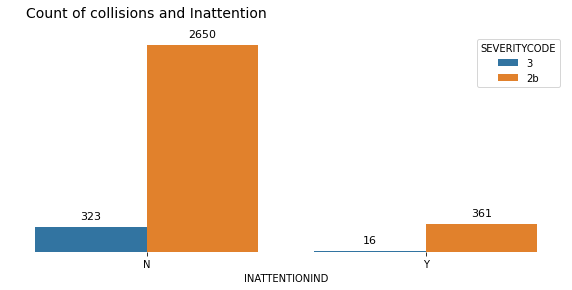

In [49]:
plt.figure(figsize=(10,4))
ax=sns.countplot(x='INATTENTIONIND', hue='SEVERITYCODE', data=focus)

ax.set_title('Count of collisions and Inattention', y=1.05, x=0.25, fontsize=14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_yaxis().set_visible(False)

for p in ax.patches:
    ax.annotate(format(p.get_height()), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=11,
                   xytext = (0, +10), 
                   textcoords = 'offset points')

figure = ax.get_figure()    
figure.savefig('inattention.png', dpi=400)

Most of the cases, the collision was not due to inattention. But let us take a better look for the cases where a pedestrian is involved.

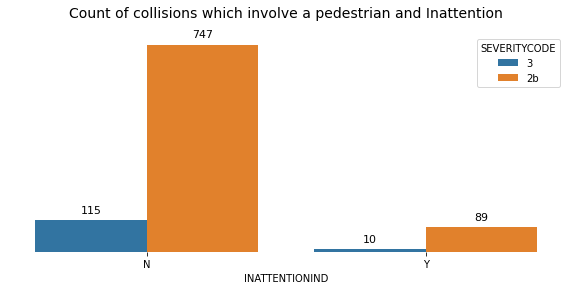

In [50]:
plt.figure(figsize=(10,4))
ax=sns.countplot(x='INATTENTIONIND', hue='SEVERITYCODE', data=focus[focus['COLLISIONTYPE']=='Pedestrian'])

ax.set_title('Count of collisions which involve a pedestrian and Inattention', y=1.05, x=0.5, fontsize=14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_yaxis().set_visible(False)

for p in ax.patches:
    ax.annotate(format(p.get_height()), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=11,
                   xytext = (0, +10), 
                   textcoords = 'offset points')

figure = ax.get_figure()    
figure.savefig('inattention.png', dpi=400)

We can see the same distribution of cases.

#### SPEEDING

In [51]:
focus['SPEEDING'].value_counts(normalize=True, dropna=False)

NaN    0.86597
Y      0.13403
Name: SPEEDING, dtype: float64

This feature content a high number of missing data. An analysis of its values reveals that the only no null value is Y = yes. So, first we need to replace those missing values to N = no. 

In [52]:
df['SPEEDING'] = df['SPEEDING'].replace(np.nan, 'N')

In [53]:
focus = df[(df['SEVERITYCODE']=='2b')|(df['SEVERITYCODE']=='3')]

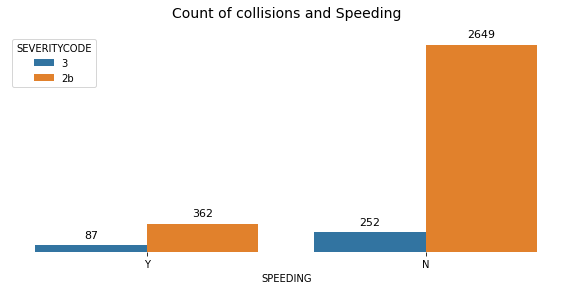

In [54]:
plt.figure(figsize=(10,4))
ax=sns.countplot(x='SPEEDING', hue='SEVERITYCODE', data=focus)

ax.set_title('Count of collisions and Speeding', y=1.05, x=0.5, fontsize=14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_yaxis().set_visible(False)

for p in ax.patches:
    ax.annotate(format(p.get_height()), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=11,
                   xytext = (0, +10), 
                   textcoords = 'offset points')

figure = ax.get_figure()    
figure.savefig('speeding.png', dpi=400)

The 30% of cases which lead on fatality were related to speeding.

## Modelling <a name="modelling"></a>

The second part of this project aims to develop a model which predict the severitycode and calculate its probability. Lets take a better look of the target variable.

In [55]:
df['SEVERITYCODE'].value_counts(normalize=True, dropna=False)

1      0.621978
2      0.265102
0      0.097473
2b     0.013880
3      0.001563
NaN    0.000005
Name: SEVERITYCODE, dtype: float64

For SEVERITYCODE == 0 we have not a detailed description of the severity of the collision or collision type. Because of that we should drop every line of data with severitycode == 0. We will do the same with NaN values.

On the other hand, we will focus on severitycode equals to 2b and 3b. So, to simplify the analyzis let us replace 1 and 2 categories to 0 and 2b, 3 to 1. 


In [56]:
df.drop(df[df['SEVERITYCODE']=='0'].index, inplace=True)
df.dropna(subset=['SEVERITYCODE'], inplace=True)

In [57]:
df['SEVERITYCODE'].replace('1', 0, inplace=True)
df['SEVERITYCODE'].replace('2', 0, inplace=True)
df['SEVERITYCODE'].replace('2b', 1, inplace=True)
df['SEVERITYCODE'].replace('3', 1, inplace=True) 
df['SEVERITYCODE'] = df['SEVERITYCODE'].astype('category')
df['SEVERITYCODE'].value_counts(normalize=True)

0    0.982889
1    0.017111
Name: SEVERITYCODE, dtype: float64

This distribution of values represents an unbalanced dataset. In this situation, the predictive model using conventional machine learning algorithms could be biases and inaccurate. A widely adopted technique for dealing with highly unbalanced datasets is called resampling. It consists of removing samples from the majority class (SEVEIRYCODE == 0) (under-sampling) and / or adding more examples from the minority class (SEVERITYCODE == 1) (over-sampling). Here we will evaluate both methodologies.

Using simpler metrics like accuracy_score can be misleading. In a dataset with highly unbalanced classes, if the classifier always "predicts" the most common class without performing any analysis of the features, it will still have a high accuracy rate. Instead to evaluate the results, we will use a confusion matrix, which shows the correct and incorrect predictions for each class. In the first row, the first column indicates how many classes 0 were predicted correctly, and the second column, how many classes 0 were predicted as 1. In the second row, we note that all class 1 entries were erroneously predicted as class 0.


In [58]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#### FEATURE SELECTION

After the analysis of collision cases under different internal and external conditions we will select the following features:
- UNDERINFL: 28% of fatality cases occur under this condition. 
- SPEEDING: 30% of fatality cases are related to speeding. 
- WEATHER:  For fatality cases, 30% of them occur under raining or overcast condition.
- ROADCOND: For fatality cases, 20% of them occur under wet road. 
- LIGHTCOND: 40% of cases with SEVERITYCODE 2b and 3 occur at dark with lights on.
- PEDROWNOTGRNT: 51% of cases with SEVERITYCODE 2b and 3 occur when pedestrian right of way were not granted.
- ADDRTYPE: Most cases occur at intersection for pedestrian collision type.
- JUNCTIONTYPE: most cases occur at midblock or at intersection.
- COLLISIONTYPE: for SEVERITYCODE 2b and 3 the main collision cases are related to pedestrian, cyclist and collision on angles.


Let us drop columns with no use for the modelling.

In [59]:
df.drop(['X', 'Y', 'LOCATION', 'PERSONCOUNT',
       'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INJURIES', 'SERIOUSINJURIES',
       'FATALITIES', 'ST_COLCODE', 'YEAR', 'MONTH', 'HOUR', 'HITPARKEDCAR'], axis=1, inplace=True)

In [60]:
x = ['UNDERINFL', 'WEATHER', 'ROADCOND', 'LIGHTCOND', 'PEDROWNOTGRNT', 'INATTENTIONIND', 'SPEEDING', 'ADDRTYPE',
      'JUNCTIONTYPE', 'COLLISIONTYPE' ]

In [61]:
df[x] = df[x].astype('category')

Becase the features selected are has diferent values, let us convert them into indicator variable.

In [62]:
df = pd.get_dummies(df, columns=x, drop_first=True, dtype='int64')

And drop all columns with NaN or Unknown.

In [63]:
df.drop(df.columns[df.columns.str.contains('NaN')], axis=1, inplace=True)

In [64]:
df.drop(df.columns[df.columns.str.contains('Unknown')], axis=1, inplace=True)

#### MODELLING AND EVALUATION

First we need to split our dataset into train and test.

In [65]:
y = df['SEVERITYCODE']
X = df.drop('SEVERITYCODE', axis=1)

In [66]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)

print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (156628, 39) (156628,)
Test set: (39158, 39) (39158,)


We need to apply sampling techniques. Because of that it is necessary to join the train data.

In [67]:
train_data = pd.concat([X_train, y_train], axis=1)

In [68]:
train_data['SEVERITYCODE'].value_counts()

0    153963
1      2665
Name: SEVERITYCODE, dtype: int64

#### UPSAMPLED

Up-sampling is the process of randomly duplicating observations from the minority class in order to reinforce its signal.

There are several heuristics for doing so, but the most common way is to simply resample with replacement.

In [69]:
from sklearn.utils import resample

First, we'll separate observations from each class into different DataFrames.
Next, we'll resample the minority class with replacement, setting the number of samples to match that of the majority class.
Finally, we'll combine the up-sampled minority class DataFrame with the original majority class DataFrame.

In [70]:
# Separate majority and minority classes
df_majority = train_data[train_data['SEVERITYCODE']==0]
df_minority = train_data[train_data['SEVERITYCODE']==1]

In [71]:
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=153963,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled['SEVERITYCODE'].value_counts()


1    153963
0    153963
Name: SEVERITYCODE, dtype: int64

In [72]:
y_up = df_upsampled['SEVERITYCODE']
X_up = df_upsampled.drop('SEVERITYCODE', axis=1)

Let's train the model using Logistic Regression on the balanced dataset:

In [73]:
from sklearn.linear_model import LogisticRegression

LR_up = LogisticRegression(C=0.01, solver='liblinear').fit(X_up,y_up)
LR_up

LogisticRegression(C=0.01, solver='liblinear')

In [74]:
yhat_up = LR_up.predict(X_test)
yhat_up

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

Confusion matrix, without normalization
[[  482   203]
 [ 7903 30570]]


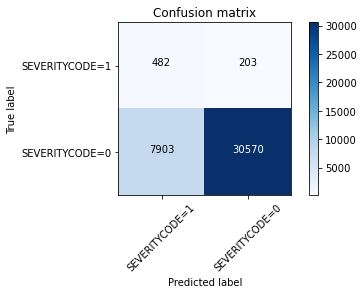

In [75]:
cnf_matrix = confusion_matrix(y_test, yhat_up, labels=[1,0])
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['SEVERITYCODE=1','SEVERITYCODE=0'],normalize= False,  title='Confusion matrix')

#### DOWNSAMPLED 

Down-sampling involves randomly removing observations from the majority class to prevent its signal from dominating the learning algorithm. The most common heuristic for doing so is resampling without replacement.

The process is similar to that of up-sampling. First, we'll separate observations from each class into different DataFrames.
Next, we'll resample the majority class without replacement, setting the number of samples to match that of the minority class.
Finally, we'll combine the down-sampled majority class DataFrame with the original minority class DataFrame.


In [76]:
# Upsample minority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=2665,     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled['SEVERITYCODE'].value_counts()

1    2665
0    2665
Name: SEVERITYCODE, dtype: int64

In [77]:
y_do = df_downsampled['SEVERITYCODE']
X_do = df_downsampled.drop('SEVERITYCODE', axis=1)

Let's train the model using Logistic Regression on the balanced dataset:

In [78]:
LR_do = LogisticRegression(C=0.01, solver='liblinear').fit(X_do,y_do)
LR_do

LogisticRegression(C=0.01, solver='liblinear')

In [79]:
yhat_do = LR_do.predict(X_test)
yhat_do

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

Confusion matrix, without normalization
[[  518   167]
 [10820 27653]]


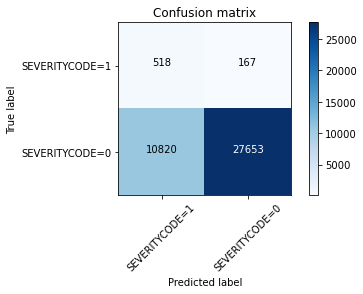

In [80]:
cnf_matrix = confusion_matrix(y_test, yhat_do, labels=[1,0])
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['SEVERITYCODE=1','SEVERITYCODE=0'],normalize= False,  title='Confusion matrix')

#### SMOTE

SMOTE (Synthetic Minority Over-sampling Technique) is a type of over-sampling procedure that is used to correct the imbalances in the groups. This technique creates new data instances of the minority groups by copying existing minority instances and making small changes to them. 

In [81]:
from imblearn.over_sampling import SMOTE

In [82]:
smt = SMOTE(random_state=0, sampling_strategy='auto', k_neighbors=1)
X_train_SMOTE, y_train_SMOTE = smt.fit_sample(X_train, y_train)

In [83]:
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train_SMOTE,y_train_SMOTE)

In [84]:
yhat_smote = LR.predict(X_test)

Confusion matrix, without normalization
[[  507   178]
 [10929 27544]]


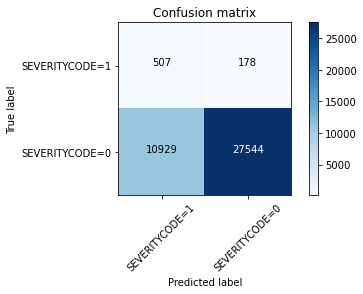

In [85]:
cnf_matrix = confusion_matrix(y_test, yhat_smote, labels=[1,0])
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['SEVERITYCODE=1','SEVERITYCODE=0'],normalize= False,  title='Confusion matrix')

## Results and Discussion <a name="results"></a>

For the last five years we can see a downward trend for global collisions in the city of Seattle. Probability it is related to the plan Vision Zero were the core of the project is the belief that death and injury on city streets is preventable. However, we cannot see the same tendency for fatality or serious injured cases. 

In the first part of the project we analysed how different internal and external condition are related to collisions with SEVERITYCODE equals to 2b and 3. In most cases those collisions are related to pedestrian and cyclist. It makes sense because they have no kind of material protection but ¿why they are involved in accidents? For pedestrians, multiple times the right of way is not granted. To solve this puzzle, we need a deeper understanding of the city design. We need to answer questions like, ¿Are there enough crosswalks? / ¿Are there enough traffic lights?

Also, for fatalities cases we see collisions were the driver was speeding or under influence of alcohol or drugs. Probably we need to focus on speed limits and how the city monitors this and analyse the necessity of implement an alcohol control on Friday evening.

Regarding modelling selection, we generate three different models. According to the confusion matrix charts we can conclude that the best performance we obtain under the downsampling model. Nevertheless, we need to improve the model because for both SEVERITYCODES, approximately 25% of entrances were predicted wrong.  


## Conclusion <a name="conclusion"></a>

The purpose of the project was to generate valuable insights to help decrease the number of collisions which end into fatalities and severity injuries. 
Most of the times the cause of them is bad human behaviour and the first step to eradicate them is to be aware of the consequences they might bring. Much of the information produced in the project may be useful for yard signs and for awareness campaigns.  On the other hand, this report invites us to go deeper into the city design to improve the experience of the pedestrian and cyclists on the street and make their travel to home safer.
The modelling will help to predict situations were the probability of a collision is higher and act preventively.
